---
# GHOS vs. Traditional Similarity Measures: A Comprehensive Study of Data Stream Classification Efficiency
---

Importing libraries.

In [1]:
import pandas as pd
import numpy as np
import math
import random

# Bibliotecas para hacer clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import LeaveOneOut
from statistics import mean 
from datetime import datetime #Ayuda a contar el tiempo de análisis en la ventana

# import collections
from itertools import groupby
# importar un 'cronómetro'
from timeit import default_timer as timer
# Para mostrar barra de progreso:
!pip install tqdm -q # Este ya esta instalado 
import time
from tqdm.notebook import tqdm_notebook
# Las siguientes línea: seaborn es para visualizar la matriz de confusión
import seaborn as sn
#Para la métrica de Minkowsky
from scipy.spatial import distance

ERROR: Invalid requirement: '#'


In [2]:
S = pd.read_csv('C:/Users/AlfaBeta/OneDrive - Instituto Politecnico Nacional/TESIS Karen\ARTÍCULO OSAKA/BD para la clasificacion/kdd_10_clases_completas.csv')
    
string = 'kdd_10_clases_completas_GHOS'

In [3]:
# Comment the following line if you want to classify all the data set
S = S[:6000] # 4200

# Parámetros de usuario

In [4]:
# Preguntar si la clase es numérica o categórica. 
# class_type lo usa preprocessing_label_coding function
class_type = 'c' #input('Is the class numeric 'n' or categorical 'c'? ')
# Introduce the instances for training the model
InitNumber = 2000 #int(input('Introduce the InitNumber: '))
# Introduce the instances for the step window
paso = 2000 #int(input('Window size: '))
# Introduce the instances for the short term memory
n_elements_stm = 100 # 50 o 100
# Introduce el numero de instancias para determinar si un cluster es válido
n_representative = 20
# Al Timestamp actual se le resta ventana_de_olvido para que instancias mas viejas
# que esa diferencia se eliminen 
ventana_de_olvido = 2000 # más grande
#paso * 0.5 # Ventana para no tener instancias viejas en el short_term_memory
mc_stm = 10 # Número de clústeres que se harán en la stm
option_g_h_o_s = 'classification' # Revisar

print('Similarity measures: 1) GHOS, 2) Jaccard_similarity, 3) Pearson correlación, 4) Minkowsky')
metrica_similitud = input('Enter the metric you want to use: ')

if int(metrica_similitud) == 4:
    p_minkowvsky = int(input('Enter the Minkowsky parameter p (can be the number 2).'))

#    Umbral_similarity = input('Ingresa la similaridad del umbral (de 1 a 4 )' )
print('Options for the calculation of the detection threshold new classes \n 1) Euclidean distances \n 2) GHOS')
# option_threshold_novel_detection = 'distancia euclidiana' / 'similitud' / 'mapeo'
option_threshold_novel_detection = 'similitud'


Similarity measures: 1) GHOS, 2) Jaccard_similarity, 3) Pearson correlación, 4) Minkowsky


Enter the metric you want to use:  1


Options for the calculation of the detection threshold new classes 
 1) Euclidean distances 
 2) GHOS


---
# Modules
---

# LABEL CODING

The following function is for convert categoric attributes to label coding.

Ordenate the dataframe as follows: label coding columns, numeric columns and CLASS columns.

The function returns:
- Preprocessed Dataframe.
- Categoric columns names.
- Numeric columns names.

In [5]:
def preprocessing_label_coding(S, class_type):
    ''' Returns a preprocessed dataframe, for categoric attributes we use label
        coding
    INPUT: 
    - S: is the dataframe.
    - class_type: is a letter c indicates categoric and n numeric.
    OUTPUT:
    - S1: is the preprocessed dataframe.
    - num_col_names: names of the numeric attributes.
    - cat_col_names: names of the categoric attributes.
    '''
    # Ask if the class is numeric or categoric.
    # class_type = input('Is the class numeric 'n' or categorical 'c'?')
    #Rename the last column
    S.columns = [*S.columns[:-1], 'CLASS']

    # Numeric columns
    S_numeric = S.select_dtypes(exclude='object') #This is a dataframe only with numeric attributes
    # Numeric colum names
    num_col_names = list(S_numeric.columns)

    # Categorical columns
    S_categorical = S.select_dtypes(include='object')
    
    # Numeric colum names
    cat_col_names = list(S_categorical.columns)
    
    # How many colums are categorical
    len_categorical = len(cat_col_names)

    # Label coding for categoric attributes
    aux_data = pd.DataFrame(columns = cat_col_names)
    # To do label coding:
    # 1. Convert object type to category type
    # 2 .cat.codes is for transform the categories to numbers
    # +1 because the labels starts at 0 and NaN -1 but I want that Nan = 0
    for i in range(len_categorical):
        aux_data[cat_col_names[i]] = S_categorical[cat_col_names[i]].astype('category').cat.codes + 1

    # S_categorical = label coding, zeros are replaced by NaN
    S_categorical = aux_data.replace(0,np.NaN)

    # ORDER my final dataframe with the following order:
    # Categoric columns, Numeric colums, Class column
    if class_type == 'c':
        class_colum = S_categorical['CLASS'] 
        print(class_colum)
        print('Se imprime la columna de clases categóricas')
        cat_class_col = S['CLASS']
        print(cat_class_col)
    
        S_categorical.drop('CLASS', axis=1, inplace=True) #Delete class_col
        cat_col_names.pop() #Eliminate CLASS for this list
        S1 = pd.concat([S_categorical,S_numeric,cat_class_col], axis=1) 
    else:
        print('numeric')
        A = S_numeric.shape
        if A[1] == 1: #If numeric columns only has the class column
            print(A[1])
            class_colum = S_numeric['CLASS']
            S1 = pd.concat([S_categorical,class_colum], axis=1) #Numeric columns will be empty
            num_col_names.pop() #Eliminate CLASS for this list
        else:
            print(A[1])
            class_colum = S_numeric['CLASS']
            S_numeric.drop('CLASS', axis=1, inplace=True)
            S1 = pd.concat([S_categorical,S_numeric,class_colum], axis=1)
            num_col_names.pop() #Eliminate CLASS for this list
    
    #print(S1)
    
    return S1, num_col_names, cat_col_names

# Initial training model


This first phase is the initial training of the algorithm. A set of labeled instances will be needed to create the initial model. 
As suggestion the Initial Number will be 2,000.

In [6]:
# - - - - - - - - - - MODEL TRAIN - - - - - - - - - -
def create_model_train(S1, InitNumber):
    ''' Create the model train  
    INPUT: 
    - S1 is the preprocessed dataframe.
    OUTPUT:
    - Model Train: son los elementos utilizads para el entrenamiento
    '''
    # InitNumber = input('Introduce the InitNumber: ')
    #InitNumber = int(InitNumber)

    # Take the first window
    model_train = S1[:InitNumber]
    # Delete the model train instances from S1
    aux_index = model_train.index.tolist()
    S1 = S1.drop(aux_index)
   
    # To convert NaN to zeros
    model_train = model_train.fillna(0)
    return S1, model_train

--- 
# Microcluster information
- Timestamp
- Number of instances. Número de instancias
- LS Linear sum. Suma lineal
- SS Cuadratic sum. Suma cuadrática
- Cj label of the class to which they belong. Etiqueta de la clase perteneciente
- Centroid. Centroide
- Radius. Radio 

In [7]:
def microcluster_information(j, i):
    '''Cálculo de la información del microcluster por 1era vez.
    Para actualizaciones del mc se usa la función update'''   
    # Time stamp
    globals()['T_'+str(Cj[j])+'_'+str(i+1)] = globals()['MC_'+str(Cj[j])+'_'+str(i+1)].index[-1]
    # Instance number
    globals()['N_'+str(Cj[j])+'_'+str(i+1)] = len(globals()['MC_'+str(Cj[j])+'_'+str(i+1)].index)
    # Lineal Sum
    globals()['LS_'+str(Cj[j])+'_'+str(i+1)] = (globals()['MC_'+str(Cj[j])+'_'+str(i+1)].sum(axis=0)).drop(labels=['CLUSTER'])
    # Square Sum
    globals()['SS_'+str(Cj[j])+'_'+str(i+1)] = np.square(globals()['MC_'+str(Cj[j])+'_'+str(i+1)]).sum(axis=0).drop(labels=['CLUSTER'])
    # Centroid LS/N
    globals()['Centroid_MC_'+str(Cj[j])+'_'+str(i+1)] = globals()['LS_'+str(Cj[j])+'_'+str(i+1)] / globals()['N_'+str(Cj[j])+'_'+str(i+1)]
    # Radius ( (SS/N) - pow(LS / N,2) ) ** 0.5
    globals()['Radius_MC_'+str(Cj[j])+'_'+str(i+1)] = ((globals()['SS_'+str(Cj[j])+'_'+str(i+1)] / globals()['N_'+str(Cj[j])+'_'+str(i+1)]) - np.square(globals()['Centroid_MC_'+str(Cj[j])+'_'+str(i+1)])) ** 0.5
    # Standard deviation
    globals()['SD_'+str(Cj[j])+'_'+str(i+1)] = np.square(globals()['MC_'+str(Cj[j])+'_'+str(i+1)].drop(['CLUSTER'], axis=1) - globals()['Centroid_MC_'+str(Cj[j])+'_'+str(i+1)]).sum(axis=0)
    # Sigma
    globals()['sigma_'+str(Cj[j])+'_'+str(i+1)] = (globals()['SD_'+str(Cj[j])+'_'+str(i+1)] / globals()['N_'+str(Cj[j])+'_'+str(i+1)]) ** 0.5

# GHOS SIMILARITY

It recives the instance and returns the max value of similarity and says in which class and cluster is.

In [8]:
def g_h_o_s(num_cluster, Cj, X_test, option_g_h_o_s):
    ''' This function applies the GHOS numeric similarity &
        applies clostest clusters centroid 4 short term memory
    INPUT: 
    - Cj: a list with class labels that have appeared
    - num_cluster: a list with the number of cluster for each class
    - instance: the instance to compare
    - option: 'similarity' means compute similarity function
            : 'euclidean' means euclidean distance
    OUTPUT: 
    - matrix (option 'similarity'): a dataframe with the clusters and classes and their similarity
    - matrix (option 'euclidean'): a dataframe with the euclidean distances between one short term
                         memory cluster and the microclusters centroids 
                         
    
    After similarity function, this function returns the cluster, class and max
        value corresponding to the X_test
    INPUT:
    - matrix: is a matrix of whom we will get the max/min cluster/class
              with classes as rows and cluster as columns
    - option: 1 maximo means class max, cluster max, and max value
              2 minimo means class min, cluster min, and min value
    OUTPUT
    - winning_class: The majority class 
    - winning_cluster: The majority cluster
    - winning_value: The majority value (ghos)
    '''
    instance = X_test
        
    # print('y test: ' + str(int(y_test)))
    # Matrix similarity clusters
    k = 0 
    columns = []   
    class_ghos = []
    index =[]
    G = []
    i_class = [] 
    i_clust = []
    
    if option_g_h_o_s == 'classification':
        
        # Entra en esta condición para calcular la máxima similitud (GHOS)
        # entre la instancia a clasificar y el centroide de cada clase.
        
        # Lo siguiente crea un vector con los valores GHOS de la instancia 
        # a clasificar respecto a cada Centroide de cada clase
        for k in range(len(Cj)): # Num of classes
            for i in range(num_cluster[k]): # Num clusters
                i_class.append('Clas_' + str(Cj[k]))
                i_clust.append('Clust_' + str(i+1))
                # - - - - GHOS numeric - - - -
                # print('Centroid_MC_'+str(Cj[k])+'_'+str(i+1))
                GHOS = (abs( instance - globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)] ) <= globals()['sigma_'+str(Cj[k])+'_'+str(i+1)]).sum(axis=1)
                #print('\n GHOS')
                #print(GHOS)
                #print('\n GHOS.iloc[0]')
                #print(GHOS.iloc[0])
                
                G.append(GHOS.iloc[0])
                #print('G append')
                
        #print('Valores de G')
        #print(G)
                
        # Ahora obtener: Values winning_class, winning_cluster y ghos
        # Quiero saber el máximo de la lista
        ghos = max(G)
        #print('GHOS máximo: ' +str(ghos))
        # Quiero saber la posición de ese valor máximo
        max_index = G.index(ghos)
        #print('Índice máximo')
        #print(max_index)
        
        #print('Quiero saber la clase donde se encuentra este máximo')
        # Caso donde la clase es categórica
        if class_type == 'c':
            winning_class = i_class[max_index].replace('Clas_', '')
            #print('class: ' +str(winning_class))
            winning_cluster = i_clust[max_index].replace('Clust_', '')
            #print('clust: ' +str(winning_cluster))
        else:  #Caso donde la clase es numérica
            winning_class = int(i_class[max_index].replace('Clas_', ''))
            #print('class: ' +str(winning_class))
            # Cluster donde se encuentra el mínimo
            winning_cluster = int(i_clust[max_index].replace('Clust_', ''))
            #print('clust: ' +str(winning_cluster))
            
       # print('class: ' +str(winning_class))
       # print('clust: ' +str(winning_cluster))
    
    elif option_g_h_o_s == 'deteccion_por_similitud':
        
        #print('Detección por similitud')
        # Hacer un vector con los clusteres de cada clase
        
        for k in range(len(Cj)): # Num of classes
            for i in range(num_cluster[k]): # Num clusters
                #print('Clase_'+str(Cj[k]))
                #print('Cluster_'+ str(i+1))
                i_class.append('Clas_' + str(Cj[k]))
                i_clust.append('Clust_' + str(i+1))
                #index.append('Clas_' + str(Cj[k]) + '_Clust_' + str(i+1))
                #print('Centroid_MC_'+str(Cj[k])+'_'+str(i+1))
                #print('sigma_'+str(Cj[k])+'_'+str(i+1))
                # - - - - GHOS numeric - - - - tiene valores booleanos que se pasan a numéricos
                GHOS = sum( abs(instance - globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)]) <= globals()['sigma_'+str(Cj[k])+'_'+str(i+1)])
                G.append(GHOS)
        #print('Valores de G')
        #print(G)

        # Values winning_class, winning_cluster y ghos
        # Quiero saber el máximo de la lista
        ghos = max(G)
        #print('Valor máximo de GHOS: ' + str(ghos))
        # Quiero saber la posición de ese valor máximo
        max_index = G.index(ghos) 
        #print('Su índice es: ' + str(max_index))
        if class_type == 'c':
            #print('la clase es categórica')
            winning_class = i_class[max_index].replace('Clas_', '')
            #print('a que clase corresponde: ' +str(winning_class))
            winning_cluster = i_clust[max_index].replace('Clust_', '')
            #print('a que cluster corresponde: ' +str(winning_cluster))
        else:
            # Quiero saber la clase donde se encuentra este minimo
            #print('la clase es numérica')
            winning_class = int(i_class[max_index].replace('Clas_', ''))
            #print('a que clase corresponde: ' +str(winning_class))
            # Cluster donde se encuentra el mínimo
            winning_cluster = int(i_clust[max_index].replace('Clust_', ''))
            #print('a que cluster corresponde: ' +str(winning_cluster))
        # print('La clase cercana es: ' + str(winning_class) + ' y el cluster cercano es: ' + str(winning_cluster))        
    
    else: #option_g_h_o_s == novel_detection
        # - - - - - - - - - - - - - -
        # En este caso se calculan distancias euclidianas de una instancia con respecto a los centroides de todos los MC
        # - - - - - - - - - - - - - -
        #print('Estamos en option_g_h_o_s' + str(option_g_h_o_s))
        # Hacer un vector con los clusteres de cada clase
        for k in range(len(Cj)): # Num of classes
            for i in range(num_cluster[k]): # Num clusters
                i_class.append('Clas_' + str(Cj[k]))
                i_clust.append('Clust_' + str(i+1))
                #index.append('Clas_' + str(Cj[k]) + '_Clust_' + str(i+1))
                #print('Centroid_MC_'+str(Cj[k])+'_'+str(i+1))
                #print('sigma_'+str(Cj[k])+'_'+str(i+1))
                # - - - - GHOS numeric - - - -
                GHOS = math.sqrt((np.square(instance - globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)])).sum())
                G.append(GHOS)
            ##print(i_class)
            ##print(i_clust)
            ##print(G)
        # Quiero saber el mínimo de la lista porque este valor es EL GHOS MÍNIMO ENTRE EL CENTROIDE DEL 
        # nuevo micro cluster y los demás micro clusters
        #print('GHOS MÍNIMO ENTRE EL CENTROIDE DEL nuevo micro cluster y los demás micro clusters: ')
        #print(G)
        ghos = min(G) #ghos = b
        ##print('GHOS: ' +str(ghos))
        # Quiero saber la posición de ese valor máximo
        min_index = G.index(ghos) 
        # print(min_index)
        if class_type == 'c':
            winning_class = i_class[min_index].replace('Clas_', '')
            winning_cluster = i_clust[min_index].replace('Clust_', '')
        else: 
            # Quiero saber la clase donde se encuentra este minimo
            winning_class = int(i_class[min_index].replace('Clas_', ''))
            # print('class: ' +str(winning_class))
            # Cluster donde se encuentra el mínimo
            winning_cluster = int(i_clust[min_index].replace('Clust_', ''))
            # print('clust: ' +str(winning_cluster))

    return winning_class, winning_cluster, ghos

# JACCARD SIMILARITY

In [9]:
def jaccard_similarity(num_cluster, Cj, X_test):
#def jaccard_similarity(num_cluster, Cj, X_test):
    ''' This function applies the Jaccard similarity
    INPUT: 
    - num_cluster: a list with the number of cluster for each class
    - Cj: a list with class labels that have appeared
    - instance: the instance to compare

    OUTPUT
    - winning_class: The majority class 
    - winning_cluster: The majority cluster
    - Jaccard: Similarity result
    '''
    # En esta métrica tanto la instancia como el Centroide que se va a comparar debe tener atributos set.
    instance = X_test.values.tolist()[0]
    instance = set(instance)

    k = 0 
    columns = []   
    class_ghos = []
    index =[]
    J = []
    i_class = [] 
    i_clust = []
       
    # Entra en esta función para calcular la máxima intersección entre la instancia a clasificar y el centroide de cada clase.
    
    # Lo siguiente crea un vector con los valores de intersección de la instancia a clasificar respecto a cada Centroide de cada cluster
    for k in range(len(Cj)): # Num of classes
        for i in range(num_cluster[k]): # Num clusters
            i_class.append('Clas_' + str(Cj[k]))
            i_clust.append('Clust_' + str(i+1))
            # - - - - JACCARD numeric - - - -
            #print('Centroid_MC' +str(Cj[k])+'_'+str(i+1))
            Centroide_provi = globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)].squeeze()
            Centroide_provi = set(Centroide_provi)
            # la métrica de Jaccard consta de la intersección con la unión entre dos elementos
            Jaccard = float(len(instance.intersection(Centroide_provi)) / len(instance.union(Centroide_provi)))
            J.append(Jaccard)
        #print('J')
        #print(J)
    #print('\n \n Valores de J')
    #print(J)

    # Ahora obtener: Values winning_class, winning_cluster y similitud
    # Quiero saber el máximo de la lista
    Jaccard = max(J)
    #print('Jaccard máximo: ' +str(Jaccard))
    # Quiero saber la posición de ese valor máximo
    max_index = J.index(Jaccard)
    #print('Índice máximo': str(max_index))

    # Quiero saber la clase donde se encuentra este minimo
    # Caso donde la clase es categórica
    if class_type == 'c':
        #print('Categoric class')
        winning_class = i_class[max_index].replace('Clas_', '')
        #print('class: ' +str(winning_class))
        winning_cluster = i_clust[max_index].replace('Clust_', '')
        #print('clust: ' +str(winning_cluster))
    else:  #Caso donde la clase es numérica
        #print('Numeric class')
        winning_class = int(i_class[max_index].replace('Clas_', ''))
        #print('class: ' +str(winning_class))
        # Cluster donde se encuentra el mínimo
        winning_cluster = int(i_clust[max_index].replace('Clust_', ''))
        #print('clust: ' +str(winning_cluster))

    #print('class: ' +str(winning_class))
    #print('clust: ' +str(winning_cluster))
    Umbral_similarity = 0.5
    
    return Umbral_similarity, winning_class, winning_cluster, Jaccard

# Pearson correlation

In [10]:
# Función de cálculo de correlación de Pearson entre listas
def pearson_corr(num_cluster, Cj, X_test):
    #def jaccard_similarity(num_cluster, Cj, X_test):
    ''' This function applies the Pearson correlation
    INPUT: 
    - num_cluster: a list with the number of cluster for each class
    - Cj: a list with class labels that have appeared
    - instance: the instance to compare

    OUTPUT
    - winning_class: The majority class 
    - winning_cluster: The majority cluster
    - Pearson: Correlation result
    '''

    instance = X_test.values.tolist()
    #print("instance: " + str(type(instance)))
   
    k = 0 
    columns = []   
    class_ghos = []
    index =[]
    P = []
    i_class = [] 
    i_clust = []
       
    # Entra en esta función para calcular la máxima intersección entre la instancia a clasificar y el centroide de cada clase.
    
    # Lo siguiente crea un vector con los valores de intersección de la instancia a clasificar respecto a cada Centroide de cada cluster
    for k in range(len(Cj)): # Num of classes
        for i in range(num_cluster[k]): # Num clusters
            i_class.append('Clas_' + str(Cj[k]))
            i_clust.append('Clust_' + str(i+1))
            # - - - - Pearson correlation - - - -
            #print('Centroid_MC' +str(Cj[k])+'_'+str(i+1))
            #Centroide_provi = globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)].squeeze()
            Centroide_provi = globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)].values.tolist()
            #print('Centroide ' + str(type(Centroide_provi)))
            #Centroide_provi = set(Centroide_provi)
            # la métrica de Jaccard consta de la intersección con la unión entre dos elementos
            
            Pearson = np.corrcoef(instance, Centroide_provi)[0][1] # Valoresde 0 a 1
            P.append(Pearson)
        #print('P')
        #print(P)
    #print('\n \n Valores de Pearson')
    #print(P)

    # Ahora obtener: Values winning_class, winning_cluster y similitud
    # Quiero saber el máximo de la lista
    Pearson = max(P)
    #print('Pearson máximo: ' +str(Pearson))
    # Quiero saber la posición de ese valor máximo
    max_index = P.index(Pearson)
    #print('Índice máximo:' + str(max_index))

    # Quiero saber la clase donde se encuentra este minimo
    # Caso donde la clase es categórica
    if class_type == 'c':
        #print('Categoric class')
        winning_class = i_class[max_index].replace('Clas_', '')
        #print('class: ' +str(winning_class))
        winning_cluster = i_clust[max_index].replace('Clust_', '')
        #print('clust: ' +str(winning_cluster))
    else:  #Caso donde la clase es numérica
        #print('Numeric class')
        winning_class = int(i_class[max_index].replace('Clas_', ''))
        #print('class: ' +str(winning_class))
        # Cluster donde se encuentra el mínimo
        winning_cluster = int(i_clust[max_index].replace('Clust_', ''))
        #print('clust: ' +str(winning_cluster))

    #print('class: ' +str(winning_class))
    #print('clust: ' +str(winning_cluster))
    Umbral_similarity = 0.5
    
    return Umbral_similarity, winning_class, winning_cluster, Pearson

# Minkowsky

In [11]:
# Función de cálculo de distancias de Minkowsky de orden p
def dist_minkowsky(num_cluster, Cj, X_test, p_minkowvsky):
    ''' This function applies the Minkowsky distance.
    Umbral similarity is changed!
    En la función de clasificación2, para que el umbral funcione, la condición de 
    if similitud >= Umbral_similarity:
    debe cambiar a 
    if Umbral_similarity >= similitud:
    para lograr esto, en el return de estafunción mandaremos el valor de similitud como el Umbral similarity
    y el valord e Umbral_similarity como el valord e similitud
    
    INPUT: 
    - num_cluster: a list with the number of cluster for each class
    - Cj: a list with class labels that have appeared
    - instance: the instance to compare

    OUTPUT
    - winning_class: The majority class 
    - winning_cluster: The majority cluster
    - Minkowsky: Correlation result
    '''
    
    instance = X_test.values.flatten().tolist()
    
    k = 0 
    columns = []   
    class_ghos = []
    index =[]
    M = []
    i_class = [] 
    i_clust = []
    
    # Lo siguiente crea un vector con los valores de intersección de la instancia a clasificar respecto a cada Centroide de cada cluster
    for k in range(len(Cj)): # Num of classes
        for i in range(num_cluster[k]): # Num clusters
            i_class.append('Clas_' + str(Cj[k]))
            i_clust.append('Clust_' + str(i+1))
            # - - - - Pearson correlation - - - -
            #print('Centroid_MC' +str(Cj[k])+'_'+str(i+1))
            #Centroide_provi = globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)].squeeze()
            Centroide_provi = globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)].values.flatten().tolist()
              
            dist_Lp0 = 0
            for r in range(len(instance)):
                dist_Lp0 += (abs(instance[r] - Centroide_provi[r]))**p_minkowvsky
                dist_Lp = dist_Lp0**(1/p_minkowvsky)

            M.append(dist_Lp)
        #print('M')
        #print(M)
    #print('\n \n Valores de Minkowsky')
    #print(M)

    # Ahora obtener: Values winning_class, winning_cluster y similitud
    # Quiero saber el máximo de la lista
    Minkow = min(M)
    #print('\n Minkowsky minimo: ' + str(Minkow))
    # Quiero saber la posición de ese valor máximo
    min_index = M.index(Minkow)
    #print('Índice mínimo:' + str(min_index))

    # Quiero saber la clase donde se encuentra este minimo
    # Caso donde la clase es categórica
    if class_type == 'c':
        #print('Categoric class')
        winning_class = i_class[min_index].replace('Clas_', '')
        #print('class: ' +str(winning_class))
        winning_cluster = i_clust[min_index].replace('Clust_', '')
        #print('cluster: ' +str(winning_cluster))
    else:  #Caso donde la clase es numérica
        #print('Numeric class')
        winning_class = int(i_class[min_index].replace('Clas_', ''))
        #print('class: ' +str(winning_class))
        # Cluster donde se encuentra el mínimo
        winning_cluster = int(i_clust[min_index].replace('Clust_', ''))
        #print('cluster: ' +str(winning_cluster))

    #print('class: ' +str(winning_class))
    #print('cluster: ' +str(winning_cluster))

    # Cálculo del umbral
    Umbral_similarity = sum(M) / len(M)
    #print('Se manda el nuevo Umbral: ' + str(Umbral_similarity)) 
    
    var_aux = Minkow
    Minkow = Umbral_similarity
    Umbral_similarity = var_aux
    del var_aux
    
    return Umbral_similarity, winning_class, winning_cluster, Minkow

# MICROCLUSTER UPDATE

After calculating the GHOS similarity value and the threshold comparision if that value is equal or bigger than the threshold, the instant test is added to its respective cluster. And it must to be updated.

In [12]:
# - - - - - - - - - - MICROCLUSTER UPDATE - - - - - - - - - -
def update_microcluster(winning_class, winning_cluster, X_test):
    ''' This function refresh cluster statistics  
    INPUT: 
    - winning_class: Class of the microcluster to be updated
    - winning_cluster: Cluster of the microcluster to be updated
    OUTPUT:
    - Microcluster updated
    '''
    # Actualización del microcluster
    # Time stamp
    globals()['T_'+str(winning_class)+'_'+str(winning_cluster)] = X_test.index[-1]
    # Instance number
    globals()['N_'+str(winning_class)+'_'+str(winning_cluster)] = 1 + globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]   
    # Lineal Sum
    globals()['LS_'+str(winning_class)+'_'+str(winning_cluster)] = X_test.iloc[0] + globals()['LS_'+str(winning_class)+'_'+str(winning_cluster)] 
    # Square Sum
    globals()['SS_'+str(winning_class)+'_'+str(winning_cluster)] = np.square(X_test.iloc[0]) + globals()['SS_'+str(winning_class)+'_'+str(winning_cluster)]
    # Centroid LS/N
    globals()['Centroid_MC_'+str(winning_class)+'_'+str(winning_cluster)] = globals()['LS_'+str(winning_class)+'_'+str(winning_cluster)] / globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]
    # Radius ( (SS/N) - pow(LS / N,2) ) ** 0.5
    globals()['Radius_MC_'+str(winning_class)+'_'+str(winning_cluster)] = ((globals()['SS_'+str(winning_class)+'_'+str(winning_cluster)] / globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]) - np.square(globals()['Centroid_MC_'+str(winning_class)+'_'+str(winning_cluster)]))**0.5
    # Standard deviation
    globals()['SD_'+str(winning_class)+'_'+str(winning_cluster)] = np.square(X_test.iloc[0] - globals()['Centroid_MC_'+str(winning_class)+'_'+str(winning_cluster)]) + globals()['SD_'+str(winning_class)+'_'+str(winning_cluster)]
    # Sigma
    globals()['sigma_'+str(winning_class)+'_'+str(winning_cluster)] = (globals()['SD_'+str(winning_class)+'_'+str(winning_cluster)] / globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]) ** 0.5

# CLASIFICATION

In [13]:
def clasificacion2(Umbral_similarity, clasificados, winning_class, winning_cluster, X_test, indice, \
    y_test, n_ventana, similitud, aciertos, aciertos_clases, short_classes, short_term_memory, \
    index_stm, clases_stm, similitud_stm, matrix_dic):
    ''' This function classify when the ghos is equal or bigger than the 
    similarity threshold, if this condition is not satisfied the instance 
    is sent to the Short Term Memory 
    INPUT:
    - clasificados: contador de las instancias que han sido clasificadas, es
                    útil para hacer el cálculo del accuracy.
    - winning_class: después de ser calculado la similitud, este es la clase del 
                    microcluster donde mas similaridad hay.
    - winning_cluster: después de ser calculado la similitud, este es la cluster 
                    perteneciente a clase del microcluster donde mas similaridad hay.
    OUTPUT: 
    - clasificados: contador de las instancias que han sido clasificadas, es
                    útil para hacer el cálculo del accuracy.
    - index: variable que ayuda para llevar un registro de como se ha realizado la clasificación
    - clases: lista que ayuda a llevar un registro de las instancias y su clasificación, contiene la siguiente
              información: clase correcta, clasificado en, número de ventana, similitud, stm, aciertos.
    - c_v_det: Lista que almacena los patrones y sus clases que fueron clasificadas correctamente en la ventana.
    - aciertos: contador para saber cuantos patrones ha clasificado (correctamente).
    - aciertos_clases: es una lista con las clases que fueron correctamente clasificadas
    - short_classes: son las clases originales/correctas de las instancias que están en
                     el Short Term Memory.
    - short_term_memory: data set of the instances belonging to short term memory.
    - index_stm: índices de las instancias en el short term memory
    - clases_stm: lista que ayuda a llevar un registro de las instancias y su clasificación, contiene la siguiente
            información: clase correcta, donde fue clasificado, en que número de ventana, valor de la similitud
    - similitud_stm: lista que almacena los valores que la instancia mandada a la STM tuvo de ghos
    - matrix_dic: es un diccionario que contiene como palabras key las clases originales y donde se clasificaron
    ''' 
    #print('HOLI1')
    if class_type == 'c': #La clase es categórica
        if similitud >= Umbral_similarity:
            ## Para calcular el accuracy se van acumulando las instancias que se clasifcaron bien o mal
            clasificados = clasificados + 1
            # Se añade esa instancia al microcluster perteneciente
            globals()['MC_'+ winning_class +'_'+ winning_cluster] = pd.concat(\
            (globals()['MC_'+ winning_class +'_'+ winning_cluster], X_test), axis = 0)   
            #print('HOLI1')
            # Las siguientes 3 líneas son para llevar un registro de 
            # instancia, clase correcta y cual clase fue asignada.
            index.append(indice)
            new_clases = {'Clase correcta': y_test.iloc[0], 'Clasificado en': winning_class,\
            'Ventana': n_ventana, 'Similitud': similitud, 'STM':'no', 'Acierto':'pasó el umbral'}
            clases.append(new_clases)
            
            #print('winning class: ' + str(winning_class) + ' y_test: ' + str(y_test))  
            
            # ¿SE CLASIFICÓ DE MANERA CORRECTA?
            if winning_class == y_test.iloc[0]: # Ya se clasificó y se hizo correctamente
                aciertos = aciertos + 1                       
                # print('aciertos: ' + str(aciertos))
                aciertos_clases.append(y_test.iloc[0])
                # Se actualizan las estadísticas SOLO SÍ la clasificación fue correcta
                update_microcluster(winning_class, winning_cluster, X_test)
                # Si no cumplió con la condición del umbral entonces se manda la instancia al STM
                matrix_dic['clase true ' + y_test.iloc[0] + ' clasificado en ' + \
                winning_class] = matrix_dic['clase true ' + y_test.iloc[0] +\
                ' clasificado en ' + winning_class] + 1

                c_v_det.append(y_test.iloc[0])

            else: # Ya se clasificó pero fue incorrecta la clasificación
                #print('Dime que clase eres y te diré en que clase te clasificaron mal')
                # print('Tu identidad es: ' + str(int(y_test)) + ' pero te disfrazaste como: ' + str(winning_class))
                # Se le suma 1 al value de esa matriz para realizar el conteo.
                #print('Clasificación INCORRECTA NO SE actualizan estadísticas')
                matrix_dic['clase true ' + y_test.iloc[0] + ' clasificado en ' + \
                winning_class] = matrix_dic['clase true ' + y_test.iloc[0] +\
                ' clasificado en ' + winning_class] + 1

        else: # No se clasificó, se manda a STM
            # Ubicar esta instancia como clase desconocida
            matrix_dic['Unknown clase ' + y_test.iloc[0]] = matrix_dic['Unknown clase '\
            + y_test.iloc[0]] + 1

            # Registrar que instancias no fueron clasificadas y a que clase corresponden
            ## print('La instancia ' + str(indice) + ' de clase ' + str(int(y_test)) + ' no \
            ##fue clasificada correctamente')
            # Almacenar las clases correctas del short term memory
            short_classes = pd.concat((short_classes, y_test.to_frame()), axis = 0)
            # El short term memory
            # La siguiente linea se cambia append por concate ya que apend en futuras versiones será removido.
            # short_term_memory = short_term_memory.append(X_test)
            short_term_memory = pd.concat((short_term_memory, X_test), axis = 0)
            # Las siguientes 3 líneas son para llevar un registro de 
            # instancia, clase correcta y cual clase fue asignada.
            new_clases_stm = {'Clase correcta': y_test.iloc[0], 'Clasificado en':'STM', 'Ventana': n_ventana, 'Similitud': similitud}
            index_stm.append(indice) #Indices de las instancias en el short term memory   
            clases_stm.append(new_clases_stm)
            # Guardar la similitud de cada instancia en el stm
            similitud_stm.append(similitud)

    else: #Si la clase es numérica
        
        if similitud >= Umbral_similarity:
            ## Para calcular el accuracy se van acumulando las instancias que se clasifcaron bien o mal
            clasificados = clasificados + 1
            # Se añade esa instancia al microcluster perteneciente
            globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)] = pd.concat(\
            (globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)], X_test), axis = 0)   

            # Las siguientes 3 líneas son para llevar un registro de 
            # instancia, clase correcta y cual clase fue asignada.
            index.append(indice)
            new_clases = {'Clase correcta': int(y_test), 'Clasificado en': winning_class,\
            'Ventana': n_ventana, 'Similitud': similitud, 'STM':'no', 'Acierto':'pasó el umbral'}
            clases.append(new_clases)

            # ¿SE CLASIFICÓ DE MANERA CORRECTA?
            if winning_class == int(y_test): #Se clasificó de manera correcta
                aciertos = aciertos + 1                       
                # print('aciertos: ' + str(aciertos))
                aciertos_clases.append(int(y_test))
                # Se actualizan las estadísticas
                update_microcluster(winning_class, winning_cluster, X_test)
            
                # Si no cumplió con la condición del umbral entonces se manda la instancia al STM
                matrix_dic['clase true ' + str(int(y_test)) + ' clasificado en ' + \
                str(winning_class)] = matrix_dic['clase true ' + str(int(y_test)) +\
                ' clasificado en ' + str(winning_class)] + 1

                c_v_det.append(int(y_test))

            else: # La clasificación no fue correcta
                #print('Dime que clase eres y te diré en que clase te clasificaron mal')
                # print('Tu identidad es: ' + str(int(y_test)) + ' pero te disfrazaste como: ' + str(winning_class))
                # NO SE ACTUALIZAN estadístuicas del MC porque la clasificación fue incorrecta.
                # Se le suma 1 al value de esa matriz para realizar el conteo.
                matrix_dic['clase true ' + str(int(y_test)) + ' clasificado en ' + \
                str(winning_class)] = matrix_dic['clase true ' + str(int(y_test)) +\
                ' clasificado en ' + str(winning_class)] + 1

        else: # No se logró clasificar, se manda a STM
            # Ubicar esta instancia como clase desconocida
            matrix_dic['Unknown clase ' + str(int(y_test))] = matrix_dic['Unknown clase '\
            + str(int(y_test))] + 1

            # Registrar que instancias no fueron clasificadas y a que clase corresponden
            ## print('La instancia ' + str(indice) + ' de clase ' + str(int(y_test)) + ' no \
            ##fue clasificada correctamente')
            # Almacenar las clases correctas del short term memory
            short_classes = pd.concat((short_classes, y_test.to_frame()), axis = 0)
            # El short term memory
            # La siguiente linea se cambia append por concate ya que apend en futuras versiones será removido.
            # short_term_memory = short_term_memory.append(X_test)
            short_term_memory = pd.concat((short_term_memory, X_test), axis = 0)
            # Las siguientes 3 líneas son para llevar un registro de 
            # instancia, clase correcta y cual clase fue asignada.
            new_clases_stm = {'Clase correcta': int(y_test), 'Clasificado en':'STM', 'Ventana': n_ventana,'Similitud': similitud}
            index_stm.append(indice) #Indices de las instancias en el short term memory   
            clases_stm.append(new_clases_stm)
            # Guardar la similitud de cada instancia en el stm
            similitud_stm.append(similitud)
    
    return clasificados, index, clases, c_v_det, aciertos, aciertos_clases, \
    short_classes, short_term_memory, index_stm, clases_stm, similitud_stm, \
    matrix_dic

---
# Short Term Memory

In [14]:
def update_t_s(short_term_memory, short_classes, Time_stamps, ventana_de_olvido):
    ''' This function updates the short term memory.
    INPUT:
    - short_memory: Data set for intances didn't recognized
    - Time_stamps: lista que contiene los índices de la última instancia de cada
                   ventana.
    - ventana_de_olvido: es un número que el usuario define. Al Timestamp actual 
                         se le resta este número para que instancias mas viejas
                         que esa diferencia se eliminen 
    OUTPUT:
    - short_term_memory: is the dataset of the short memory updated
    - short_classes: is the dataframe of classes correspondind to the short memory updated.
    '''
    # Update time stamp
    current_t_s = Time_stamps[-1] #Current time stamp
    update_time = current_t_s - ventana_de_olvido # difference_time_stamp es el factor de olvido
    short_term_memory = short_term_memory.loc[update_time:, :]
    short_term_memory
    # Update short_classes 
    aux_index = short_term_memory.index.tolist()
    short_classes = short_classes.loc[aux_index]
    
    return short_term_memory, short_classes

In [15]:
# function to get unique values 
def unique(lista): 
    '''
    Esta función da valores únicos en una lista
    INPUT:
    - lista: es una lista donde se quieren obtener sus valores únicos
    OUTPUT:
    - valores: son los elementos únicos en esa lista.
    '''
    valores = []  
    # insert the list to the set 
    list_set = set(lista) 
    # convert the set to the list 
    unique_list = (list(list_set)) 
    for valor in unique_list: 
        valores.append(valor)
        # print(x)
    return valores

In [16]:
def clases_en_ventana(lista_clases):
    ''' Esta función regresa un diccionario con la clase y número de instancias que hay.
    INPUT:
    - clases_totales: es una lista con todas las etiquetas de clases presentadas en la ventana
    OUTPUT:
    - n_v: el diccionario donde indica clase y número de instancias
    '''
    
    # Clases e instancias TOTALES por ventana
    lista_clases = sorted(lista_clases, reverse=False) # La lista se arregla de mayor a menor.
    # lista_clases_unique = unique(lista_clases) # Se obtienen los valores únicos (clases)
    # ¿Qué clases hay en esta ventana?
    clases_ventana = list(Counter(lista_clases).keys())
    # ¿Cuántas instancias hay de cada clase de esta ventana?
    instancias_x_clase = list(Counter(lista_clases).values())
    
    diccionario_clases = {}   
        
    for i in range(len(clases_ventana)):
        aux_dic = {clases_ventana[i] : instancias_x_clase[i] }
        diccionario_clases.update(aux_dic)

    return diccionario_clases

In [17]:
def clusters_en_ventana(Cj, num_clusters):
    ''' Esta función regresa en forma de diccionario las clases detectadas 
    y sus clusters creados.
    INPUT:
    - Cj: es una lista que contiene las etiquetas de clases detectadas
    -num_clusters: es una lista con el número de clusters por cada clase
    OUTPUT:
    - diccionario_clusters: es un diccionario que relaciona la clase y el número total de los clusters creados
    '''  

    Cluster_v = []
    for i in Cj:
        Cluster_v.append('cluster_clase_'+str(i))
    
    num_c = num_clusters.copy()
    diccionario_clusters = {} 
    for key in Cluster_v: 
        for value in num_c: 
            diccionario_clusters[key] = value 
            num_c.remove(value) 
            break
    return diccionario_clusters

---
# PREPROCESSING.
---

In [18]:
S

,attrib1,attrib2,attrib3,attrib4,attrib5,attrib6,attrib7,attrib8,attrib9,attrib10,...,attrib33,attrib34,attrib35,attrib36,attrib37,attrib38,attrib39,attrib40,attrib41,CLASS
0,0,tcp,private,S0,0,0,0,0,0,0,...,11,0.04,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune.
1,0,tcp,http,SF,350,1082,0,0,0,0,...,250,1.00,0.00,0.06,0.06,0.00,0.01,0.00,0.00,normal.
2,0,udp,private,SF,105,0,0,0,0,0,...,245,0.96,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal.
3,0,tcp,private,S0,0,0,0,0,0,0,...,4,0.02,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune.
4,0,tcp,http,SF,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.01,0.01,0.04,0.04,back.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0,udp,private,SF,105,146,0,0,0,0,...,250,0.98,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal.
5996,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,smurf.
5997,0,tcp,http,SF,229,1462,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.
5998,0,tcp,http,SF,322,236,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.


In [19]:
# - - - - - - - - - - - - - - - - STREAM DATA SET - - - - - - - - - - - - - - - - -
S
# - - - - - - - - - - - - - - - - Delete attrib0 column - - - - - - - - - - - - - - - - - 
# Here we have a little problem, the first column is unnecessary, 
# so we must to eliminate but not having a name will not be possible so
# we must rename it and after that eliminate.
S.rename( columns={'Unnamed: 0':'attrib0'}, inplace=True )
#del S['attrib0']

# - - - - - - - - - - - - - - - - Rearrange our database - - - - - - - - - - - - - - - -
# First columns: categorical
# After categorical columns: numerical
# CLASS column
S1, num_col_names, cat_col_names = preprocessing_label_coding(S, class_type)
clases_originales = S1['CLASS']

rows = S1.shape[0]
attributes = S1.shape[1]
print('Your dataset has ' + str(rows) + ' instances and ' + str(attributes) + ' attributes')
# - - - - - - - - NÚMERO TOTAL DE CLASES - - - - - - - - - - - - 
C_tot = clases_originales.value_counts(sort=True)
C_tot = C_tot.keys()
C_tot = C_tot.tolist()
print('The total classes that your stream has are the following ones: ')
print(C_tot)

0       3
1       5
2       5
3       3
4       1
       ..
5995    5
5996    8
5997    5
5998    5
5999    5
Name: CLASS, Length: 6000, dtype: int8
Se imprime la columna de clases categóricas
0       neptune.
1        normal.
2        normal.
3       neptune.
4          back.
          ...   
5995     normal.
5996      smurf.
5997     normal.
5998     normal.
5999     normal.
Name: CLASS, Length: 6000, dtype: object
Your dataset has 6000 instances and 42 attributes
The total classes that your stream has are the following ones: 
['smurf.', 'neptune.', 'normal.', 'satan.', 'portsweep.', 'ipsweep.', 'back.', 'nmap.', 'warezclient.', 'teardrop.']


In [20]:
S1[0:5]

,attrib2,attrib3,attrib4,attrib1,attrib5,attrib6,attrib7,attrib8,attrib9,attrib10,...,attrib33,attrib34,attrib35,attrib36,attrib37,attrib38,attrib39,attrib40,attrib41,CLASS
0,2,35,5,0,0,0,0,0,0,0,...,11,0.04,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune.
1,2,17,6,0,350,1082,0,0,0,0,...,250,1.00,0.00,0.06,0.06,0.00,0.01,0.00,0.00,normal.
2,3,35,6,0,105,0,0,0,0,0,...,245,0.96,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal.
3,2,35,5,0,0,0,0,0,0,0,...,4,0.02,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune.
4,2,17,6,0,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.01,0.01,0.04,0.04,back.


---
---
---
# Naıve Associative Classifier for Online Data (NACOD)
---
---
---

In [21]:
# Model train
S1, model_train = create_model_train(S1, InitNumber)

In [22]:
len(S1)

4000

In [23]:
# - - - - - - - - - - - - - - - Identify how many classes we have - - - - - - - - - - - - - - - 
# Classes of my model train
Cj = model_train.iloc[:,-1]
# Count classes by label
Cj = Cj.value_counts(sort=True)
Cj

smurf.          1134
neptune.         435
normal.          395
satan.             6
back.              5
portsweep.         5
ipsweep.           5
teardrop.          5
warezclient.       5
nmap.              5
Name: CLASS, dtype: int64

In [24]:
# - - - - - - - - - - - - - - - LABEL CLASSES - - - - - - - - - - - - - - -
Cj = Cj.keys()
Cj = Cj.tolist()
#length = len(Cj)
Cj

['smurf.',
 'neptune.',
 'normal.',
 'satan.',
 'back.',
 'portsweep.',
 'ipsweep.',
 'teardrop.',
 'warezclient.',
 'nmap.']

In [25]:
# - - - Obtener un D_# por cada clase - SUBSETS OF THE TRAINING DATASET - - - - - - - - - - - - - - -
j = 0
for i in range(len(Cj)):
    globals()['D_'+str(Cj[i])] = model_train[model_train['CLASS']==Cj[i]]
    globals()['D_'+str(Cj[i])].pop('CLASS') # Eliminate class
    #    model_train[model_train['CLASS'].str.match(Cj[i])] #if the classes were categorical
del model_train # Lo borramos
# D_1
# D_2

---
# CLUSTERING
---

---
# K_means
Apply the K means algorithm in each D_x, we will asked how many clusters do we want for each x.

Result: 
 * Centroid of each cluster (4) in D_x (8 centroids) 
 * MC_x in wich the CLASS colum will be changed by CLUSTER column based in which instance belongs to what cluster.
---

In [26]:
##### - A los sets de cada clase se les añade una columna al final la cual
# indica el numero de cluster al que pertenece cada instancia
j = 0
num_cluster = [] # Empty list for number of clusters
for i in range(len(Cj)): # How many Dj
    j = i+1
    # Se hace el Kmeans con n clústers
    num_cluster.append(int(input('Number of clusters for D_'+str(Cj[i])+'? ')))
    globals()['kmeansD_'+str(Cj[i])] = KMeans(n_clusters=int(num_cluster[-1]), random_state=0).fit(globals()['D_'+str(Cj[i])])
    # Obtener los centroides de cada cluster
    globals()['centroidsD_'+str(Cj[i])] = globals()['kmeansD_'+str(Cj[i])].cluster_centers_ 
    # Column_series es el array de a cuál cluster pertenecen las instancias
    column_series = pd.Series(globals()['kmeansD_'+str(Cj[i])].labels_ + 1)
    # Ese array lo pasamos a forma de Dataframe
    globals()['MC_'+str(Cj[i])] = column_series.to_frame()
    # Para poderlo concatenar al model train tenemos que hacer que los índices de las instancias cuadren
    globals()['MC_'+str(Cj[i])].index = globals()['D_'+str(Cj[i])].index
    # Renombramos a la columna con la palabra CLUSTERcehc
    globals()['MC_'+str(Cj[i])].rename( columns={0:'CLUSTER'}, inplace=True )
    globals()['MC_'+str(Cj[i])] = pd.concat([globals()['D_'+str(Cj[i])],globals()['MC_'+str(Cj[i])]], axis=1) 

# del D_1 # Se elimina
# del D_3 # Se elimina
# MC_1
# MC_2

Number of clusters for D_smurf.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters for D_neptune.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Number of clusters for D_normal.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Number of clusters for D_satan.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of clusters for D_back.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of clusters for D_portsweep.?  4


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of clusters for D_ipsweep.?  4


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of clusters for D_teardrop.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of clusters for D_warezclient.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Number of clusters for D_nmap.?  5


C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AlfaBeta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [27]:
# Se crean los micro clusteres - - MC_j_i -  j es la clase - i el cluster - - - - -
j = 0
n_c = []
for j in range(len(Cj)): # Número de clases
    for i in range(num_cluster[j]): # Número de clusters 
        globals()['MC_'+str(Cj[j])+'_'+str(i+1)] = globals()['MC_'+str(Cj[j])][globals()['MC_'+str(Cj[j])]['CLUSTER']==i+1]
        n_c.append(len(globals()['MC_'+str(Cj[j])+'_'+str(i+1)]))
        # Escribir archivos csv
        #globals()['MC_'+str(Cj[j])+'_'+str(i+1)].to_csv('MC_'+str(Cj[j])+'_'+str(i+1)+'.csv')
    del globals()['MC_'+str(Cj[j])]

In [28]:
n_c # numero de instancias pertenecientes a cada cluster

[915,
 144,
 1,
 72,
 2,
 87,
 121,
 118,
 101,
 8,
 347,
 1,
 36,
 6,
 5,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

# Micro clusters información.
Se llama a la funcion 'microcluster_information' para obtener la siguiente información:
- Timestamp, Number of instances. Número de instancias, LS Linear sum. Suma lineal
- SS Cuadratic sum. Suma cuadrática, Cj label of the class to which they belong. Etiqueta de la clase perteneciente
- Centroid. Centroide, Radius. Radio 

In [29]:
# - - MC_j_i - - - INFORMATION - - - - average vector for numeric attributes
# missing to obtain Mode vector for categorical attributes.
for j in range(len(Cj)): # Num of classes
    for i in range(num_cluster[j]): # Num of clusters
        # Time stamp
        microcluster_information(j,i)

# Métricas

In [30]:
def dic_matrix(C_tot):
    '''
    Función que crea un diccionario en un ciclo for para ir almacenando en que clase las 
    instancias fueron clasificadas
    INPUT:
    - C_tot: es una lista de las clases totales que hay en nuestro datastream
    OUTPUT:
    - matrix_dic: es un diccionario que contiene como palabras key las clases originales y donde se clasificaron
    '''
    matrix_dic = {}
    zero = 0
    #Ciclo for
    C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
    
    for clase in range(len(C_tot)):
        for clasificado in range(len(C_tot)):
            aux_dic = {'clase true ' + str(C_tot_ordenado[clase]) + ' clasificado en ' + str(str(C_tot_ordenado[clasificado])): zero}
            matrix_dic.update(aux_dic)
        aux_dic = {'Unknown clase ' + str(C_tot_ordenado[clase]): zero}
        matrix_dic.update(aux_dic)
    return matrix_dic

In [31]:
def imprimir_confussion_matrix(C_tot, Cj, matrix_dic):
    '''
    Función que regresa la matriz de confusión representada en un gráfico
    INPUT:
    - C_tot: es una lista de las clases totales que hay en nuestro datastream
    - Cj: a list with class labels that have appeared
    - matrix_dic: es un diccionario que contiene como palabras key las clases originales y donde se clasificaron
    OUTPUT:
    - Devuelve un gráfico
    '''
    print('\n - - - - - - - - - - MATRIZ DE CONFUSIÓN - - - - - - - - - ')
    # - - - - - - - CLASES TOTALES - - - - - - - - - - - - - -
    C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
    
    #- - - - - - - - - CLASES QUE HAN APARECIDO - - - - - - - - 
    Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
    
    lista = []
    for true in range(len(C_tot)): # Este for recorre las clases totales
        aux_lista = []
        for predicho in range(len(Cj)): # este for recorre las clases que han sido descubiertas
            # print('True: ' + str(C_tot_ordenado[true]) + ' Predicho: ' + str(Cj_ordenado[predicho]))
            #Aquí viene el diccionario
            aux_lista.append(matrix_dic['clase true ' + str(C_tot_ordenado[true]) + ' clasificado en ' + str(Cj_ordenado[predicho])]) 
            # print(diccionario['clase true ' + str(C_tot_ordenado[true]) + ' clasificado en ' + str(Cj_ordenado[predicho])]) 
        aux_lista.append(matrix_dic['Unknown clase ' + str(C_tot_ordenado[true])])

        #'Unknown clase ' + str(C_tot_ordenado[clase])
        lista.append(aux_lista)
    lista

    # Crear los índices de las clases que aparecerán en todo el dataset
    true = []
    for i in range(len(C_tot_ordenado)):
        true.append(C_tot_ordenado[i])

    #Crear los nombres de las columnas de las clases que se van descubriendo
    predicted = []
    for i in range(len(Cj)):
        predicted.append(Cj_ordenado[i])
    predicted.append('Unknown')

    #df_confusion = pd.crosstab(true, predicted, rownames=['Real'],colnames=['Predicho'])
    #no_detect = df_confusion.iloc[:,0]
    #cm = df_confusion.iloc[:,1:7]
    #print(no_detect)
    # print(df_confusion)

    print('Filas: clases reales \n Columnas: clases predichas.')
    df_cm = pd.DataFrame(lista, true, predicted)
    print(df_cm)
    
    
    # - - - - - - - - - IMPRIMIR MATRIZ DE CONFUSIÓN
    plt.figure(figsize = (15, 14))
    sn.heatmap(df_cm, annot=True)
    
    print('Se imprime matriz de confusión')
    sn.heatmap(df_cm, annot = True, annot_kws={'size': 17} ,cmap = 'Greens', fmt='.1f')
    

In [32]:
def df_clasificaciones(C_tot, Cj, num_cluster, n_ventana, Time_stamps,\
    accuracy_ventana, ElapseTime, c_v_tot, cero, matrix_dic, CER_ventana, \
    Unk_ventana, b_T):
    ''' 
    Función para crear un dataframe donde se almacenen las clasificaciones por ventana
    INPUT: 
    - C_tot: es una lista de las clases totales que hay en nuestro datastream
    - Cj: a list with class labels that have appeared
    - num_cluster: es una lista que me indica cuantos clusters hay por clase, \
                   se debe de leer con Cj para entenderlo.
    - n_ventana: es un entero que especifica el número de ventana que se está analizando
    - Time_stamps: lista que contiene los índices de la última instancia de cada
                   ventana.
    - accuracy_ventana: es el número obtenido de los patrones que fueron clasificados
                        correctamente en esa ventana.
    - ElapseTime: es el tiempo que tardó una ventana en ejecutarse.
    - c_v_tot: diccionario que indica cuantas clases y patrones respectivos a esas
               clases fueron presentados en la ventana correspondiente. 
    - cero: es el número cero, el cual será colocado en caso de que cierta clase 
            en cierta ventana no haya tenido instancias.
    - matrix_dic: es un diccionario que contiene como palabras key las clases 
                  originales y donde se clasificaron
    - CER_ventana: métrica propuesta en el artículo de MINAS, es la sumatoria de 
                   los Falsos Positivos más los falsos negativos de cada clase
                   dividido entre 2.
    - Unk_ventana:
    - b_T:
    
    OUTPUT: 
    - clasificacion:
    '''
    #print('\n accuracy_ventana')
    #print(accuracy_ventana)
    #print(type(accuracy_ventana))
    
    # Clusteres de cada clase por ventana
    cluster_ventana = clusters_en_ventana(Cj, num_cluster)
    
    # Dataframe de clasificaciones
    C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
    Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
    
    #print('accuracy_ventana[-1][0]: ' + str(type(accuracy_ventana[-1][0])))
    
    clasificacion = {'Ventana': n_ventana, 'TS': Time_stamps[-1], \
    'Accuracy': accuracy_ventana[-1][0],\
    'CER': CER_ventana[-1][0], \
    'Unk': Unk_ventana[-1][0], \
    'Tiempo transcurrido [sec]': ElapseTime} 
    #lista = [55, 54]                      
    aux_A = {}
    aux_B = {}
    aux_C = {}
    
    
    if class_type == 'c': # Si la clase es categórica
    # En este for va lo que se repite 1 vez por clase  
        for clase in range(len(C_tot)):
            aux_col = {'Instancias presentadas clase_' + C_tot[clase]: \
            c_v_tot[C_tot[clase]] if c_v_tot.get(C_tot[clase]) else cero}

            aux_col_1 = {'Unknown clase ' + C_tot[clase]: \
            matrix_dic['Unknown clase ' + C_tot[clase]], \
            'Numero de clusters en clase_' + C_tot[clase]: \
            cluster_ventana['cluster_clase_' + C_tot[clase]] 
            if cluster_ventana.get('cluster_clase_' + C_tot[clase]) else cero}
            aux_A = {}
                #En este for va lo que se repite varias veces por clase
                # En este cico for van las clasificaciones que se hicieron por cada clase 
            for clase2 in range(len(C_tot)):      
                aux_col_3 = {'Clase '+ C_tot[clase] + ' predicha en ' +\
                C_tot[clase2]: matrix_dic['clase true ' + \
                C_tot[clase] + ' clasificado en ' + C_tot[clase2]]}
                aux_A = {**aux_A, **aux_col_3} 

        #for cluster in 
            aux_B = {**aux_col, **aux_A, **aux_col_1}
            aux_C = {**aux_C, **aux_B}
            #aux_C = {**aux_C, **T}
        
    else:# Si la clase es numérica
        # En este for va lo que se repite 1 vez por clase
        for clase in range(len(C_tot)):            
            aux_col = {'Instancias presentadas clase_' + str(C_tot_ordenado[clase]): \
            c_v_tot[C_tot_ordenado[clase]] if \
            c_v_tot.get(C_tot_ordenado[clase]) else cero}

            aux_col_1 = {'Unknown clase ' + str(C_tot_ordenado[clase]): \
            matrix_dic['Unknown clase ' + str(C_tot_ordenado[clase])], \
            'Numero de clusters en clase_' + str(C_tot_ordenado[clase]): \
            cluster_ventana['cluster_clase_' + str(C_tot_ordenado[clase])] 
            if cluster_ventana.get('cluster_clase_' + str(C_tot_ordenado[clase])) else cero}
            aux_A = {}
                #En este for va lo que se repite varias veces por clase
                # En este cico for van las clasificaciones que se hicieron por cada clase 
            for clase2 in range(len(C_tot)):      
                aux_col_3 = {'Clase '+ str(C_tot_ordenado[clase]) + ' predicha en ' +\
                str(C_tot_ordenado[clase2]): matrix_dic['clase true ' + \
                str(C_tot_ordenado[clase]) + ' clasificado en ' + str(C_tot_ordenado[clase2])]}
                aux_A = {**aux_A, **aux_col_3} 

        #for cluster in 

            aux_B = {**aux_col, **aux_A, **aux_col_1}
            aux_C = {**aux_C, **aux_B}
            #aux_C = {**aux_C, **T}
    #print(aux_C)
    
    #print('\n AQUI DEBEN DE IR LAS ESTADÍSTICAS')
    
    aux_A = {}
    aux_B = {}
    
    # Almacena el número de instacias que tiene cada microcluster
    if class_type == 'c':
        for clase in range(len(Cj)):
            for i in range(num_cluster[clase]): # Num of clusters
                aux_A = {'N_' + Cj[clase] + '_'+ str(i+1) : globals()['N_' + Cj[clase] + '_' + str(i+1)]}
                #print('N_' + Cj[clase] + '_'+ str(i+1))
                #print(globals()['N_' + Cj[clase] + '_'+ str(i+1)])
                aux_B = {**aux_B, **aux_A}
    else:
        for clase in range(len(Cj)):
            for i in range(num_cluster[clase]): # Num of clusters
                aux_A = {'N_' + str(Cj[clase]) + '_'+ str(i+1) : globals()['N_' + str(Cj[clase]) + '_'+ str(i+1)]}
                #print('N_' + str(Cj[clase]) + '_'+ str(i+1))
                #print(globals()['N_' + str(Cj[clase]) + '_'+ str(i+1)])
                aux_B = {**aux_B, **aux_A}

    diccionario = {}
    for cluster in range(mc_stm):
        #print(cluster+1)
        aux = {}
        aux = {'b cluster ' + str(cluster+1): b_T.pop(0),
        'T cluster ' + str(cluster+1): b_T.pop(0)}
        #print(aux)
        diccionario = {**diccionario, **aux}
    #print('DICCIONARIO: ')
    #print(diccionario)
    
    
    clasificacion = {**clasificacion, **aux_C, **aux_B, ** diccionario}
    #clasificacion = {**clasificacion, **aux_C}
    #print('\n CLASIFICACIÓN')
    #print(clasificacion)
    
    return clasificacion

In [33]:
def CER_Unk_function(C_tot, Cj, c_v_tot, matrix_dic, clasificados):
    '''
    Esta función nos devuelve la métrica CER, propuesta en el algoritmo de MINAS
    '''
    # - - - - - - - - - SE OBTIENEN UNK TP, FP, FN, TN - - - - - - - - 
    Unk = 0 
    #FP = 0 
    C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
    Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
    
    ExCi = 0
    
    CER_clase = CER = 0
    
    for clase in range(len(C_tot)):
        TP = FP = FN = TN = 0 
        #print('FP: ' + str(FP) + '. TP: ' + str(TP) + '. FN: ' + str(FN) + '. FP: ' + str(FP))
        #print('\n \n CLASE: ' +  C_tot[clase] )
        ExC_clasificados = 0
        ExC_clasificados = c_v_tot[C_tot[clase]] if c_v_tot.get(C_tot[clase]) else cero 
        ExC_clasificados = ExC_clasificados - matrix_dic['Unknown clase ' + str(C_tot[clase])]        
        #print('\n instancias clasificadas de la CLASE REAL: ' + C_tot[clase] + ' = ' + str(ExC_clasificados))
        #print('clasificados: ' + str(clasificados))
        
        #print('\n Unk_i: ' + str(matrix_dic['Unknown clase ' + str(C_tot[clase])]))            
        ExCi = matrix_dic['clase true ' + str(C_tot[clase]) + ' clasificado en ' + str(C_tot[clase])] + \
        matrix_dic['Unknown clase ' + str(C_tot[clase])]
        
        # print('ExCi clase true ' + str(C_tot[clase]) + 'clasificado en ' + str(C_tot[clase]))
            
        if ExCi != 0: # Si hay ejemplos de esa clase
            # print('División: ' + str(matrix_dic['Unknown clase ' + str(C_tot[clase])] / ExCi) )
            Unk = Unk + ( matrix_dic['Unknown clase ' + str(C_tot[clase])] / ExCi )
            # print('Se van sumando los desconocidos por clase: ' + str(Unk))

        else: # Si no se presentan ejemplos de esa clase
            # print('ExCi es cero porque aun no hay oatrones de esa clase')
            Unk = Unk + 0
            
        # - - - - - - - - - - - CALCULO DE CER - - - - - - - - - - - 
        TP = matrix_dic['clase true ' + str(C_tot[clase]) + ' clasificado en ' + str(C_tot[clase])]
        #print('TP_' + C_tot[clase] + ' = ' + str(TP))
        clasif = 0
        for clase2 in range(len(C_tot)):
            if clase != clase2:
                #print('FP true: ' + Cj[clase2] + 'clasificado en:' + Cj[clase] + ' = ' + str(FP) )
                #print('FN: true: ' + Cj[clase] + ' clasificado en: ' + Cj[clase2] + ' = ' + str(FN))
                FP = FP + matrix_dic['clase true ' + str(C_tot[clase2]) + ' clasificado en ' + str(C_tot[clase])]
                #print('FP true: ' + C_tot[clase2] + 'clasificado en:' + C_tot[clase] + ' = ' + str(FP) )
                FN = FN + matrix_dic['clase true ' + str(C_tot[clase]) + ' clasificado en ' + str(C_tot[clase2])]
                for clase3 in range(len(C_tot)):
                    if clase3 != clase:
                        #print('TN clase true: ' + Cj[clase2] + 'clasificado en: ' + Cj[clase3] + ' = ' + str(TN))
                        TN = TN + matrix_dic['clase true ' + str(C_tot[clase2]) + ' clasificado en ' + str(C_tot[clase3])]
            # ¿Cuántos clasificados de esa clase hubo?
            clasif = clasif + matrix_dic['clase true ' + str(C_tot[clase]) + ' clasificado en ' + str(C_tot[clase2])]
        
#        print('FP_' + C_tot[clase] + ' = ' + str(FP))
#        print('FN_' + C_tot[clase] + ' = ' + str(FN))        
#        print('TN_' + C_tot[clase] + ' = ' + str(TN))
#        print('Clasif ' + C_tot[clase] + ' = ' + str(clasif) )
#        print('Clasificados = ' + str(clasificados) )
#        print('\n')
        if clasificados != 0:
            div = clasif/clasificados
        else:
            div = 0
        # - - - Evitar división entre cero - - - 
        # FPR
        if FP + TN == 0:
#            print('divisor de FPR da cero')
            FPR = 0
        else:
            FPR = FP / (FP + TN) ## TPR = 1 - FPR
        
        if FN + TP == 0:
#            print('divisor de FNR da cero')
            FNR = 0
        else:
            FNR = FN / (FN + TP)  ## TNR = 1 - FNR
            
        #################################################
        ## BA = (TPR + FNR) / 2
        ## https://en.wikipedia.org/wiki/Confusion_matrix
        #################################################
        
#        print('division: ' + str(div))
#        print('FPR_' + str(C_tot[clase]) + ' = ' + str(FPR) )
#        print('FNR_' + str(C_tot[clase]) + ' = ' + str(FNR) )
#        print('CER_' + str(C_tot[clase]) + str((div*FPR) + (div*FNR)))
        
        CER_clase = (div*FPR) + (div*FNR)
#        print('CER antes de acumularse : ' +str(CER))
        CER = CER + CER_clase
#        print('div: ' + str(div))
#        print('FPR: ' + str(FPR))
#        print('FNR: ' + str(FNR))
#        print('CER acumulativo: ' + str(CER))
#        print('\n')
            
    #print('Valor de Unk final: ' + str(Unk))
                         
    Unk = Unk / len(C_tot)
#    print('Esto vale Unk: ' + str(Unk))

    TP = FP = FN = TN = 0
    CER = CER / 2
    #print('Unk: ' + str(Unk))
#    print('CER FINAL: ' + str(CER))
    #print('\n ')

    return Unk, CER

# Metric for classifying instances in data stream (WITHOUT novel class)

In [34]:
def clasif_DS_CK(C_tot, Cj, c_v_tot, matrix_dic, clasificados):
    '''
    Esta función nos devuelve las métricas balanced Accuracy, K y MCC
    '''
    C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
    #print('C_tot_ordenado')
    #print(C_tot_ordenado)
    Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
    #print('Cj_ordenado')
    #print(Cj_ordenado)
    
    #print('\n ------ MATRIX DIC -------- \n')
    #print(matrix_dic)
    #print('--------------- \ n')
    
    TP = []
    FN = []
    FP = []
    TN = []
    
    for clase in range(len(C_tot)):
        #print('\n \n CLASE: ' +  C_tot[clase] )
        TP_aux = matrix_dic['clase true ' + str(C_tot[clase]) + ' clasificado en ' + str(C_tot[clase])]
        TP.append(TP_aux)
        #print(TP)
        
        for clase2 in range(len(C_tot)):
            if clase != clase2:
                #print('\n Clase: ' + C_tot[clase] + ' con clase2: ' + C_tot[clase2])
                FN_aux = matrix_dic['clase true ' + str(C_tot[clase]) + ' clasificado en ' + str(C_tot[clase2])]
                FN.append(FN_aux)
                
                FP_aux = matrix_dic['clase true ' + str(C_tot[clase2]) + ' clasificado en ' + str(C_tot[clase])]
                FP.append(FP_aux)
               
                for clase3 in range(len(C_tot)):
                    if clase3 != clase:
                        #print('TN clase true: ' + Cj[clase2] + 'clasificado en: ' + Cj[clase3] + ' = ' + str(TN))
                        TN_aux = matrix_dic['clase true ' + str(C_tot[clase2]) + ' clasificado en ' + str(C_tot[clase3])]
                        TN.append(TN_aux)
                        
    #print('\n TP = ' + str(TP))
    #print('\n FN = ' + str(FN))
    #print('\n FP = ' + str(FP))
    #print('\n TN = ' + str(TN))
    
    # Promedios
    print('\n Promedios: \n')
    TP = sum(TP)/len(C_tot)
    #print('TP:' +str(TP))
    
    FN = sum(FN)/len(C_tot)
    #print('FN:' +str(FN))
    
    FP = sum(FP)/len(C_tot)
    #print('FP:' +str(FP))
    
    TN = sum(TN)/len(C_tot)
    #print('TN:' +str(TN))
    
    ############################################################################ RATES ################################################
    if TP+FN != 0:
        TPR = TP/(TP+FN)
    else:
        TPR = 0
        
    if TN+FP != 0:
        TNR = TN /(TN+FP)
    else:
        TNR = 0
    ################# Balanced accuracy #######################
    BA = (TPR + TNR)/2
    ########################### kappa index #############################
    if ((TP+FP) * (FP+TN) + (TP+FN) * (FN+TN) ) != 0:
        kappa_index = (2* (TP * TN - FP * FN))/((TP+FP) * (FP+TN) + (TP+FN) * (FN+TN) )
    else:
        kappa_index = 0
    # worst value = -1; best value = + 1
    ########################### Mathews Correlation Coefficient #############################
    if (math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))) != 0:
        MCC = (TP*TN-FP*FN)/ (math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
    else:
        MCC = 0
    #print('MCC: ' + str(MCC))
    # worst value = -1; best value = + 1
    return TP, FN, FP, TN, TPR, TNR, BA, kappa_index, MCC

In [35]:
def df_evaluacion_DS_ck(n_ventana, Time_stamps, TP, FN, FP, TN, TPR, TNR, BA, kappa_index, MCC):
    """
    FUNCIÓN que ayuda a crear un data frame con las evaluaciones
    """
    #print('TP[-1][0]')
    #print(TP[-1][0])
    
    evaluacion = {'Ventana': n_ventana, 'TS': Time_stamps[-1], 'TP': TP,\
    'FN': FN, 'TP': TP, 'FP': FP, 'TN': TN, 'TPR': TPR, 'TNR': TNR, 'BA': BA, 'kappa_index': kappa_index, 'MCC': MCC}

    
    return evaluacion
    

# Online phase.

Classification
---

This is how the classes and their respective clusters begin.
['smurf.', 'neptune.', 'normal.', 'satan.', 'back.', 'portsweep.', 'ipsweep.', 'teardrop.', 'warezclient.', 'nmap.']
with the following clusters:
[5, 5, 5, 5, 5, 4, 4, 5, 5, 5]
These are the classes that appear in the entire data set:
['smurf.', 'neptune.', 'normal.', 'satan.', 'portsweep.', 'ipsweep.', 'back.', 'nmap.', 'warezclient.', 'teardrop.']
The option for the detection of new classes is: similitud
half_attributes: 21.0


  0%|          | 0/2 [00:00<?, ?it/s]


 Windows length: 2000
Accuracy calculated by correct number of sorted patterns.
hits: 1906, clasifieds: 2000, accuracy: [95.3]

 Observations in STM: 0 at the top of the window
NO ANALYSIS WAS CARRIED OUT AT THE STM

 Promedios: 


 - - - - - - - - - - MATRIZ DE CONFUSIÓN - - - - - - - - - 
Filas: clases reales 
 Columnas: clases predichas.
              back.  ipsweep.  neptune.  nmap.  normal.  portsweep.  satan.  \
back.             1         0         0      0        2           0       0   
ipsweep.          0         5         0      0        0           0       0   
neptune.          0         0       355      1        1          84       0   
nmap.             0         0         0      2        1           0       0   
normal.           0         0         0      0      409           3       0   
portsweep.        0         0         0      0        0           2       0   
satan.            0         0         0      0        0           0       6   
smurf.            0     

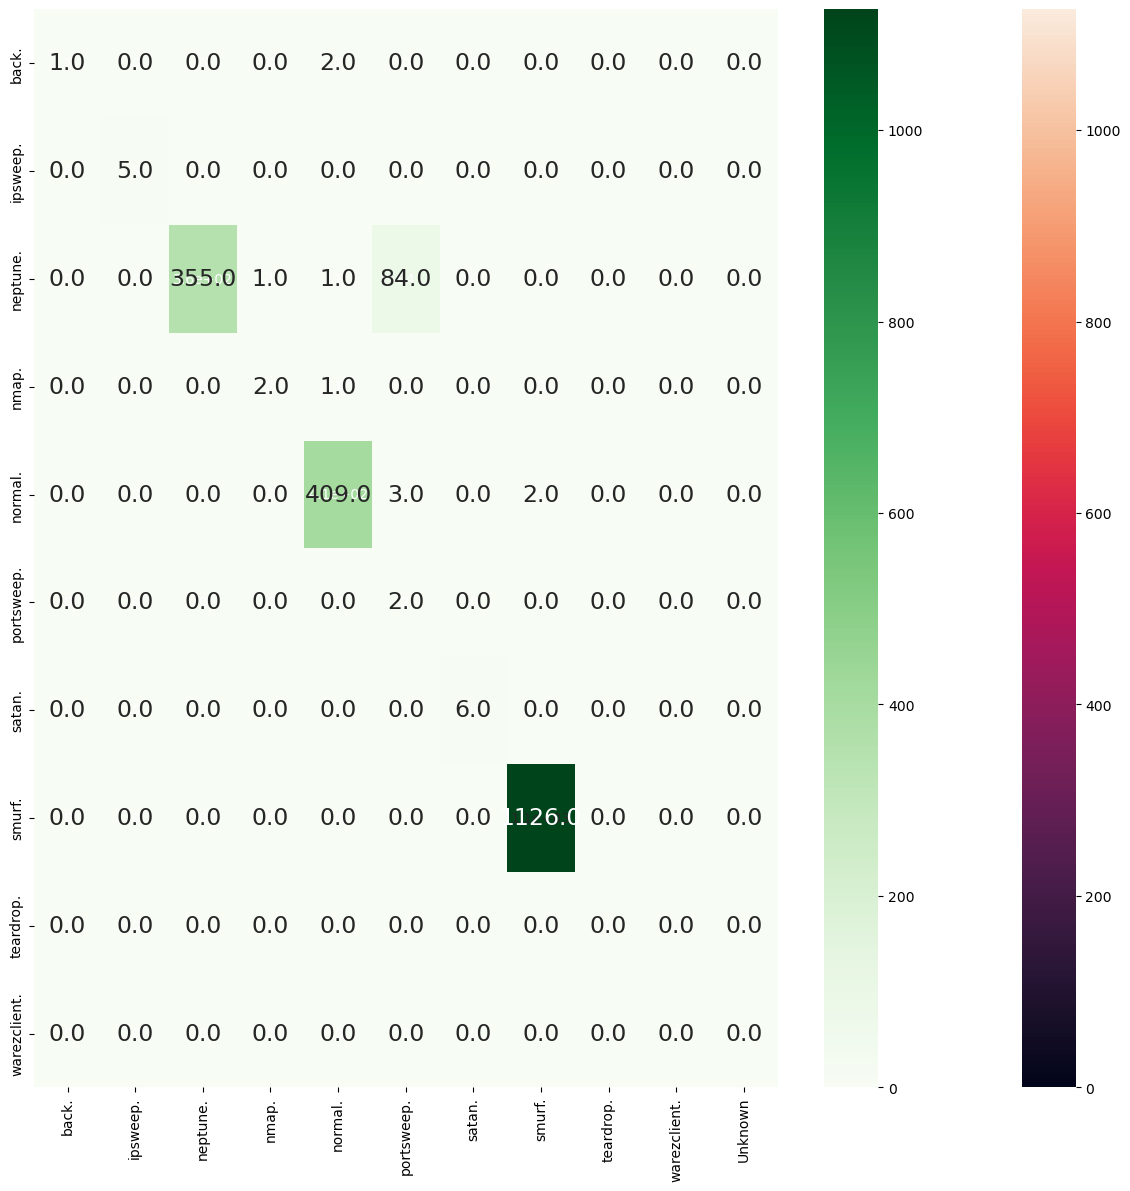

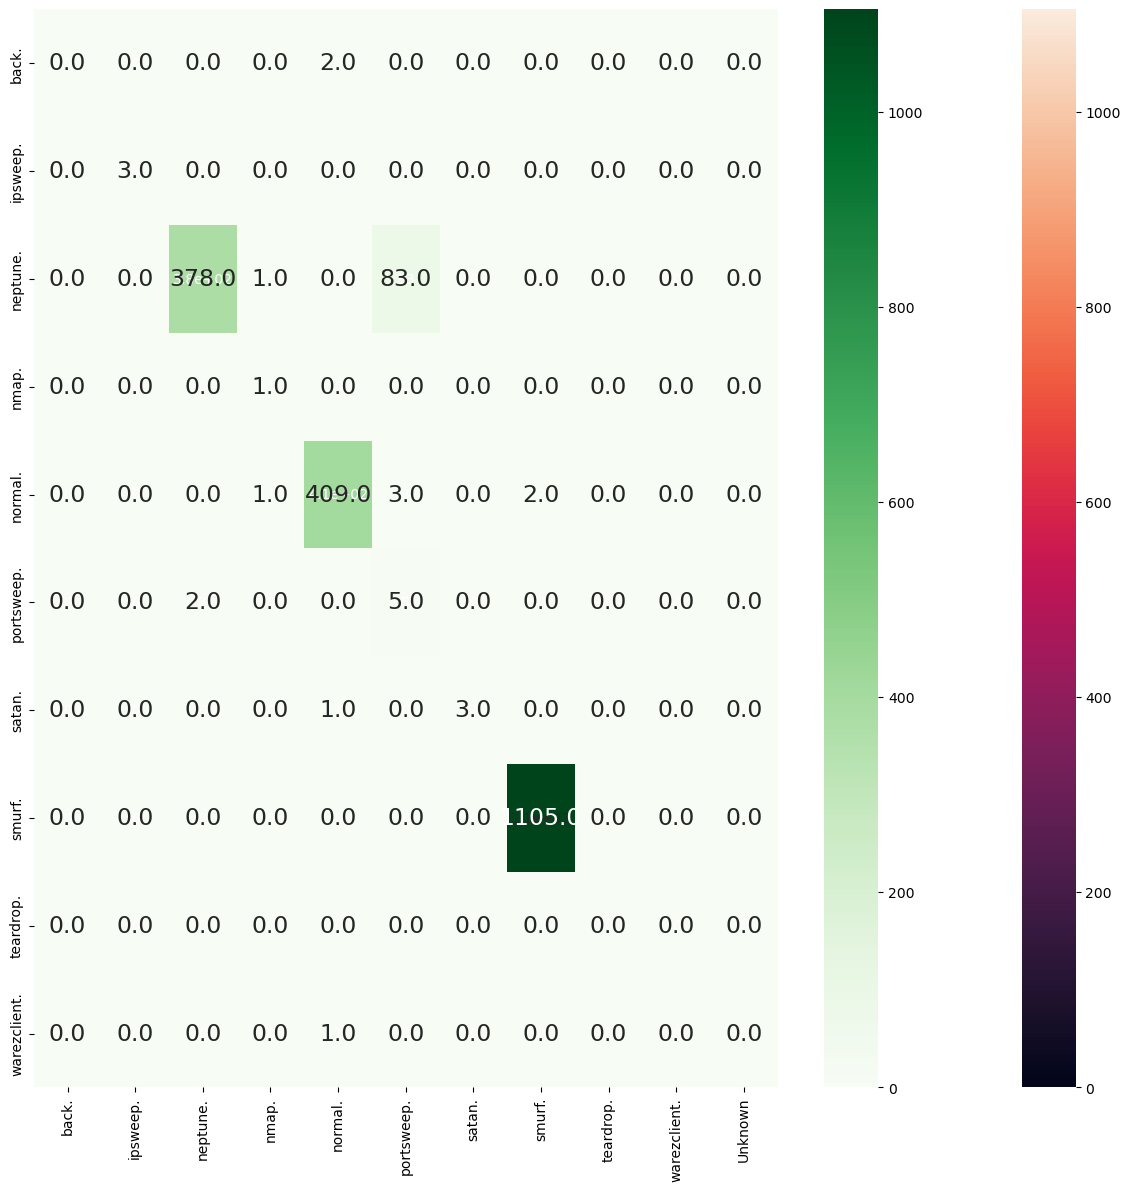

In [36]:
total = len(S1)
#ventana = 0
n_ventana = 0
Time_stamps = [ ]
cero = 0
columns = ['Clase correcta', 'Clasificado en', 'Ventana', 'GHOS', 'STM', 'Acierto']
columns_stm = ['Clase correcta', 'Clasificado en', 'Ventana', 'GHOS']
col_clasif_stm = ['Clase_correcta', 'Clasificado en', 'GHOS', 'Acierto', 'Ventana']
index_no_emerging = []
col_no_emerging = ['Ventana', 'Cluster STM', 'clase original', 'clase propuesta', 'error', 'instancias', 'T']
no_emerging = [] 
clases = []
clases_stm = []
clasif_right_stm = []
clasif_wrong_stm = []
index = []
index_stm= []
index_right_stm = []
index_wrong_stm = []
index_time = [] # Para dataframe de tiempo
clasificaciones = []
similitud_stm = []
accuracy_ventana = []
Unk_ventana = []
CER_ventana = []
aciertos_clases =[]
aciertos_stm = 0
short_term_memory = pd.DataFrame()
short_classes = pd.DataFrame()
evaluaciones = []

#While para recorrer todo el dataset
print('This is how the classes and their respective clusters begin.')
print(Cj)
print('with the following clusters:')
print(num_cluster)
print('These are the classes that appear in the entire data set:')
print(C_tot)
print('The option for the detection of new classes is: ' + str(option_threshold_novel_detection))
half_attributes = attributes/2
print('half_attributes: ' + str(half_attributes))

while S1.size != 0:
    for i in tqdm_notebook(range(0, math.ceil(total/paso))):
        clasificados = 0
        #print('\n clasificados: ' + str(clasificados))
        aciertos = 0
        window = S1[:paso] #window contiene las instancias de la ventana
        Time_stamps.append(window.index[-1])
        # Aquí las instancias se borran del dataset y se pasan a la ventana
        aux_index = window.index.tolist()
        S1 = S1.drop(aux_index)
        n_ventana = n_ventana + 1
        c_v_tot = [] # Es una lista vacía para almacenar cuantos patrones
        # y a qué clase pertenecen por ventana.  
        c_v_det = [] # Es una lista vacía que almacena la clase de la instancia
        # que está siendo analizada solo si fue clasificada correctamente
        matrix_dic = dic_matrix(C_tot) # Diccionario que almacena las instancias y donde se clasificaron erróneamente.
        
        print('\n Windows length: ' + str(len(window)))
        ventana_size = len(window)
        TimeInit = timer()

        while window.size != 0:
            # Start nos ayuda a medir el tiempo de inicio de la ventana
            start = timer()
            X_test = window.iloc[[0]].drop(['CLASS'], axis=1)
            y_test = window.iloc[[0]]['CLASS']

            
            if class_type == 'c':
                c_v_tot.append(y_test.iloc[0])
            else:
                c_v_tot.append(int(y_test)) # Aquí se van almacenando las clases que se presentan en la ventana
            # print(c_v_tot[-1])
            indice = X_test.index.tolist()[0]
            analysis = 0 #Significa que no se ha hecho análisis a la stm
            #print('indice' + str(indice))
            # Aquí la instancia a analizar se borra de la ventana
            aux_index = X_test.index.tolist()
            window = window.drop(aux_index)

            ####################### FUNCION GHOS #### PARA  #############################
            ####################### LA #### CLASIFICACION ###############################
            #print('metrica_similitud ' + metrica_similitud)
            if int(metrica_similitud) == 1: # Métrica ghos
                winning_class, winning_cluster, similitud = g_h_o_s(num_cluster, Cj, X_test, option_g_h_o_s)
                Umbral_similarity = round(attributes/2)
            elif int(metrica_similitud) == 2: # Métrica Jaccard
                Umbral_similarity, winning_class, winning_cluster, similitud = jaccard_similarity(num_cluster, Cj, X_test)
            elif int(metrica_similitud) == 3: # Métrica Pearson
                Umbral_similarity, winning_class, winning_cluster, similitud = pearson_corr(num_cluster, Cj, X_test)
            elif int(metrica_similitud) == 4: # Minkowsky
                Umbral_similarity, winning_class, winning_cluster, similitud = dist_minkowsky(num_cluster, Cj, X_test, p_minkowvsky)            
            ##########################################################################
            #del ghos
            ################## CLASIFICACIÓN #######################
            # Tiempo desde que inicia la clasificación
            start_clasif = timer()
            
            clasificados, index, clases, c_v_det, aciertos, aciertos_clases, short_classes, short_term_memory, \
            index_stm, clases_stm, similitud_stm, matrix_dic = clasificacion2(Umbral_similarity, clasificados, \
            winning_class, winning_cluster, X_test, indice, y_test, n_ventana, similitud, aciertos, \
            aciertos_clases, short_classes, short_term_memory, index_stm, clases_stm, similitud_stm, matrix_dic)
                
                
        # --- CALCULOS DE TIEMPO ----
        TimeFin = timer()            
        ElapseTime = TimeFin - TimeInit #Tiempo 
          # print('Tiempo transcurrido: ' + str(ElapseTime/60))
        
        # Clases e instancias TOTALES por ventana
        c_v_tot = clases_en_ventana(c_v_tot)
        c_v_det = clases_en_ventana(c_v_det)
        
        #- - - - - - - - - - - - ACCURACY - - - - - - - - - - - - - - - - 
        print('Accuracy calculated by correct number of sorted patterns.')
        #print('clasificados: ' + str(clasificados))
        if clasificados != 0:
            accuracy_ventana.append([(aciertos/clasificados)*100])
        else:
            # print('Accuracy cero, no se clasificó correctamente ninguna instancia')
            #print(' esto afectó la función CER_Unk en sus líneas 64 a la 67')
            accuracy_ventana.append([0])
        print('hits: ' + str(aciertos) + ', clasifieds: ' + str(clasificados) + ', accuracy: ' + str(accuracy_ventana[-1]))
        
        
        ################ ANÁLISIS STM #########################################
        #######################################################################
        ti_stm = timer() # Tiempo inicial del análisis de la stm

        print('\n Observations in STM: ' + str(len(short_term_memory)) + ' at the top of the window')

        # Si cumple la condición, se analiza la STM
        # print('valor de analysis: ' + str(analysis))
        
        if len(short_term_memory)>= n_elements_stm and analysis != 0:
            # Me da las instancias mandadas al short term memory
            instancias_stm = pd.DataFrame(clases_stm, index_stm, columns_stm)   
           # Creación de los clusters en el stm
            Clusters, n_clusters_stm = clusters_stm(short_term_memory, mc_stm)          
            # - - - - - - ANÁLISIS DE LA SHORT TERM MEMORY - - - - - - - - - 
            # Las siguientes 5 líneas hacen referencia a la función que checa si el cluster
            # es o no válido. Si es válido, hace la asignación como extensión de la clase
            # o clase emergente.
            Cj, short_term_memory, num_cluster, ShortCluster,short_classes,\
            aciertos_stm,index_right_stm, clasif_right_stm,index_wrong_stm, \
            clasif_wrong_stm, b_T = analysis_stm(short_term_memory, short_classes, \
            Clusters, n_clusters_stm,Cj, clases_originales, num_cluster, \
            aciertos_stm, index_right_stm, clasif_right_stm, index_wrong_stm, \
            clasif_wrong_stm, instancias_stm, n_ventana, n_representative, option_threshold_novel_detection)

            
            #- - - - - - - - - - - ACTUALIZACIÓN DE LA SHORT TERM MEMORY - - - - - - - - - -
            short_term_memory, short_classes = update_t_s(short_term_memory, short_classes,\
            Time_stamps, ventana_de_olvido)
            # Se eliminan los clusteres que se realizaron en este análisis de la STM
            del Clusters

            print('\n = = = = = = = = = = \n Number of STM observations: ' + str(len(short_term_memory)) + ' at the window end \n = = = = = = = = = = \n')
        
        else: # Es decir analysis == 0:
            print('NO ANALYSIS WAS CARRIED OUT AT THE STM')
            b_T = [0] * mc_stm * 2
            # se llama la función para calcular las métricas de evalaución
            TP, FN, FP, TN, TPR, TNR, BA, kappa_index, MCC = clasif_DS_CK(C_tot, Cj, c_v_tot, matrix_dic, clasificados)
            # Se crea un data frame con estos valores
            evaluacion = df_evaluacion_DS_ck(n_ventana, Time_stamps, TP, FN, FP, TN, TPR, TNR, BA, kappa_index, MCC)
            evaluaciones.append(evaluacion)

        # - - - - - - CONFUSION MATRIX - - - - - -
        #print('IMPRIMIR MATRIZ')
        imprimir_confussion_matrix(C_tot, Cj, matrix_dic)
        
        #Función para obtener la métrica CER
        Unk, CER = CER_Unk_function(C_tot, Cj, c_v_tot, matrix_dic, clasificados)
        
        Unk_ventana.append([Unk])
        CER_ventana.append([CER])
        
        print('\n METRICS')
        print('Unk: ' + str(Unk))
        print('CER: ' + str(CER) + '\n')
        
        clasificacion = df_clasificaciones(C_tot, Cj, num_cluster, n_ventana, \
        Time_stamps, accuracy_ventana, ElapseTime, c_v_tot, cero, matrix_dic, \
        CER_ventana, Unk_ventana, b_T)
        
        index_time.append(n_ventana) #
        clasificaciones.append(clasificacion)
        
        print('The classes and their respective clusters are as follows.')
        print(Cj)
        print(num_cluster)
        
      
        print('\n The window ended: ' + str(n_ventana) + ' Time Stamp: ' +  str(Time_stamps[-1]) + ' t: ' + str(ElapseTime) + '[sec]' + ' accuracy ' + str(accuracy_ventana[-1][0]) \
        + ' Balanced Accuracy:' +str(BA) )
        print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
        print('\n  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
        time.sleep(0.01)
    # Si la clase 1 aun no aparece en Cj entonces ponemos esos valores iguales a cero

-----
-----
-----

In [37]:
Cj

['smurf.',
 'neptune.',
 'normal.',
 'satan.',
 'back.',
 'portsweep.',
 'ipsweep.',
 'teardrop.',
 'warezclient.',
 'nmap.']

In [38]:
Cj[Cj.index(winning_class)]

'normal.'

In [39]:
num_cluster[Cj.index(winning_class)]

5

In [40]:
accuracy_ventana

[[95.3], [95.19999999999999]]

---
---
# Guardar y graficar información
---
---

# Guardar el accuracy

In [41]:
# Importing library 
import csv
# opening the csv file in 'w+' mode 
file = open('accuracy_' + str(string) +'.csv', 'w+', newline ='')# writing the data into the file 
with file:     
    write = csv.writer(file) 
    write.writerows(accuracy_ventana) 

In [42]:
Cj

['smurf.',
 'neptune.',
 'normal.',
 'satan.',
 'back.',
 'portsweep.',
 'ipsweep.',
 'teardrop.',
 'warezclient.',
 'nmap.']

In [43]:
C_tot

['smurf.',
 'neptune.',
 'normal.',
 'satan.',
 'portsweep.',
 'ipsweep.',
 'back.',
 'nmap.',
 'warezclient.',
 'teardrop.']

# Guardar métricas de evaluación

In [44]:
Columns_eval = ['Ventana', 'TS', 'TP', 'FN', 'TP', 'FP', 'TN', 'TPR', 'TNR', 'BA', 'kappa_index', 'MCC']
print(evaluaciones)

[{'Ventana': 1, 'TS': 3999, 'TP': 190.6, 'FN': 9.4, 'FP': 9.4, 'TN': 1790.6, 'TPR': 0.953, 'TNR': 0.9947777777777778, 'BA': 0.9738888888888888, 'kappa_index': 0.9477777777777778, 'MCC': 0.9477777777777778}, {'Ventana': 2, 'TS': 5999, 'TP': 190.4, 'FN': 9.6, 'FP': 9.6, 'TN': 1790.4, 'TPR': 0.9520000000000001, 'TNR': 0.9946666666666667, 'BA': 0.9733333333333334, 'kappa_index': 0.9466666666666669, 'MCC': 0.9466666666666669}]


In [45]:
print(index_time)

[1, 2]


In [46]:
Columns_eval

['Ventana',
 'TS',
 'TP',
 'FN',
 'TP',
 'FP',
 'TN',
 'TPR',
 'TNR',
 'BA',
 'kappa_index',
 'MCC']

In [47]:
Evaluaciones = pd.DataFrame(evaluaciones, index_time, Columns_eval)

In [48]:
Evaluaciones.to_csv('Evaluaciones_' + str(string) +'.csv')

# Guardar tiempos

In [49]:
# Dataframe de clasificaciones

#if class_type == 'c'

C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
columns_clasificaciones = ['Ventana', 'TS', 'Accuracy', 'CER', 'Unk', 'Tiempo transcurrido [sec]']
#lista = [55, 54]                      
aux_A = []
aux_B = []
aux_C = []

if class_type == 'c': # Si la clase es categórica2
    # En este for va lo que se repite 1 vez por clase
    for clase in range(len(C_tot)):        
        aux_col = ['Instancias presentadas clase_' + C_tot[clase]]
        aux_col_1 = ['Unknown clase ' + C_tot[clase], \
        'Numero de clusters en clase_' + C_tot[clase]]
        aux_A = []
        #En este for va lo que se repite varias veces por clase
        # En este cico for van las clasificaciones que se hicieron por cada clase 
        for clase2 in range(len(C_tot)):      
            #print('Clase '+ C_tot[clase] + ' predicha en ' + C_tot[clase2])
            aux_col_3 = ['Clase '+ C_tot[clase] + ' predicha en ' + C_tot[clase2]]
            aux_A = aux_A + aux_col_3
        #B = B + aux_col + A
        aux_B = aux_col + aux_A + aux_col_1
        aux_C = aux_C + aux_B

    
else: # Si la clase es numérica
    # En este for va lo que se repite 1 vez por clase
    for clase in range(len(C_tot)):
        aux_col = ['Instancias presentadas clase_' + str(C_tot_ordenado[clase])]
        aux_col_1 = ['Unknown clase ' + str(C_tot_ordenado[clase]), \
        'Numero de clusters en clase_' + str(C_tot_ordenado[clase])]
        aux_A = []
        #En este for va lo que se repite varias veces por clase
        # En este cico for van las clasificaciones que se hicieron por cada clase 
        for clase2 in range(len(C_tot)):      
            aux_col_3 = ['Clase ' + str(C_tot_ordenado[clase]) + ' predicha en ' + str(C_tot_ordenado[clase2])]
            aux_A = aux_A + aux_col_3
        #B = B + aux_col + A
        aux_B = aux_col + aux_A + aux_col_1
        aux_C = aux_C + aux_B
    
# Incluir el número de instancias de cada micro-cluster
aux_A = aux_B = aux_D = []

if class_type == 'c':
    for clase in range(len(Cj)):
        for i in range(num_cluster[clase]): # Num of clusters
            aux_A = ['N_' + str(Cj[clase]) + '_'+ str(i+1)]                
            # print('N_' + Cj[clase] + '_'+ str(i+1))
            aux_B = aux_B + aux_A
        aux_B = aux_B + aux_A
    #print('AUX B')
    #print(aux_B)
    
else:
    for clase in range(len(Cj)):
        for i in range(num_cluster[clase]): # Num of clusters
            aux_A = ['N_' + Cj[clase] + '_'+ str(i+1)]                
            # print('N_' + Cj[clase] + '_'+ str(i+1))
            aux_B = aux_B + aux_A
        aux_B = aux_B + aux_A
    #print('AUX B')
    #print(aux_B)

#print('Aux_B')
#print(aux_B)

diccionario = []
for cluster in range(mc_stm):
    aux = []
    aux = ['b cluster ' + str(cluster+1), 'T cluster ' + str(cluster+1)]
    diccionario = diccionario + aux


columns_clasificaciones = columns_clasificaciones + aux_C + aux_B + diccionario
#print('clasificaciones columnas')
#print(columns_clasificaciones)

#print('Así quedan las columnas')
# print(columns_clasificaciones)
Tiempos = pd.DataFrame(clasificaciones, index_time, columns_clasificaciones)
Tiempos
print(Tiempos)

   Ventana    TS  Accuracy       CER  Unk  Tiempo transcurrido [sec]  \
1        1  3999      95.3  0.024427  0.0                 216.855959   
2        2  5999      95.2  0.025105  0.0                 216.306133   

   Instancias presentadas clase_smurf.  Clase smurf. predicha en smurf.  \
1                                 1126                             1126   
2                                 1105                             1105   

   Clase smurf. predicha en neptune.  Clase smurf. predicha en normal.  ...  \
1                                  0                                 0  ...   
2                                  0                                 0  ...   

   b cluster 6  T cluster 6  b cluster 7  T cluster 7  b cluster 8  \
1            0            0            0            0            0   
2            0            0            0            0            0   

   T cluster 8  b cluster 9  T cluster 9  b cluster 10  T cluster 10  
1            0            0          

In [50]:
print(Tiempos)

   Ventana    TS  Accuracy       CER  Unk  Tiempo transcurrido [sec]  \
1        1  3999      95.3  0.024427  0.0                 216.855959   
2        2  5999      95.2  0.025105  0.0                 216.306133   

   Instancias presentadas clase_smurf.  Clase smurf. predicha en smurf.  \
1                                 1126                             1126   
2                                 1105                             1105   

   Clase smurf. predicha en neptune.  Clase smurf. predicha en normal.  ...  \
1                                  0                                 0  ...   
2                                  0                                 0  ...   

   b cluster 6  T cluster 6  b cluster 7  T cluster 7  b cluster 8  \
1            0            0            0            0            0   
2            0            0            0            0            0   

   T cluster 8  b cluster 9  T cluster 9  b cluster 10  T cluster 10  
1            0            0          

In [51]:
Tiempos.to_csv('Tiempos_' + str(string) +'.csv')

--------

# Guardar microclusteres creados

In [52]:
# Se guardan los micro clusteres creados- - MC_j_i -  j es la clase - i el cluster - - - - -
j = 0
n_c = []
for j in range(len(Cj)): # Número de clases
    for i in range(num_cluster[j]): # Número de clusters 
        # Escribir archivos csv
        globals()['MC_'+str(Cj[j])+'_'+str(i+1)].to_csv('MC_'+str(Cj[j])+'_'+str(i+1)+'.csv')

# Guardar los patrones clasificados por el NACOD

In [53]:
# Dataframe de las instancias clasificadas correctamente
patrones_clasificaciones_NACOD = pd.DataFrame(clases, index, columns)
patrones_clasificaciones_NACOD.to_csv('patrones_clasificaciones_NACOD.csv')
patrones_clasificaciones_NACOD

,Clase correcta,Clasificado en,Ventana,GHOS,STM,Acierto
2000,smurf.,smurf.,1,NaN,no,pasó el umbral
2001,smurf.,smurf.,1,NaN,no,pasó el umbral
2002,smurf.,smurf.,1,NaN,no,pasó el umbral
2003,smurf.,smurf.,1,NaN,no,pasó el umbral
2004,smurf.,smurf.,1,NaN,no,pasó el umbral
...,...,...,...,...,...,...
5995,normal.,normal.,2,NaN,no,pasó el umbral
5996,smurf.,smurf.,2,NaN,no,pasó el umbral
5997,normal.,normal.,2,NaN,no,pasó el umbral
5998,normal.,normal.,2,NaN,no,pasó el umbral


# Guardar los patrones mandados a STM

Son todas las instancias que NACOD no pudo clasificar y se fueron a la memoria corta.

In [54]:
# Dataframe del histórico de la información de las instancias que llegaron al
# short term memory durante la ejecución del programa.
patrones_mandados_a_STM = pd.DataFrame(clases_stm, index_stm, columns_stm)
patrones_mandados_a_STM.to_csv('patrones_mandados_a_STM.csv')
patrones_mandados_a_STM

,Clase correcta,Clasificado en,Ventana,GHOS


# Patrones que se detectaron en extensión o en nueva clase pero que son erroneos.

In [55]:
index_no_emerging = list(range(1,len(no_emerging)+1))
Clases_no_emerging = pd.DataFrame(no_emerging, index_no_emerging, col_no_emerging)
Clases_no_emerging.to_csv('Clusters_desechados.csv')
Clases_no_emerging

,Ventana,Cluster STM,clase original,clase propuesta,error,instancias,T


---
---

In [56]:
# Como queda STM al final del análisis
short_term_memory # STM Actualizado
short_term_memory.to_csv('STM_actualizada.csv')

In [57]:
# Clases correctas de la STM
short_classes # Clases de la STM Actualizadas
short_classes.to_csv('STM_clases_actualizadas.csv')

---
---
---

# Métrica CER

In [58]:
Unk_ventana

[[0.0], [0.0]]

In [59]:
#plt.plot(DataChunk, Unk_ventana, label = 'Unk')
plt.plot(DataChunk, CER_ventana, label = 'CER')
plt.plot(DataChunk, Unk_ventana, label = 'Unk')
plt.xlabel('Time Stamps (in Thousands)')
plt.ylabel('Evaluation measure value:')
plt.title('CER')
plt.legend()
plt.savefig('CER-Unk.jpg')
plt.show()

NameError: name 'DataChunk' is not defined

---
---
---